In [1]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

All done


In [2]:
Path_data = '/Users/kunalgoyal/Desktop/DR'
data = os.listdir(Path_data)
Healthy = os.listdir('/Users/kunalgoyal/Desktop/DR/Healthy')
Mild = os.listdir('/Users/kunalgoyal/Desktop/DR/Mild DR')
Moderate = os.listdir('/Users/kunalgoyal/Desktop/DR/Moderate DR')
Proliferate = os.listdir('/Users/kunalgoyal/Desktop/DR/Proliferate DR')
Severe = os.listdir('/Users/kunalgoyal/Desktop/DR/Severe DR')

In [3]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Mild DR', 'Healthy', 'Moderate DR', 'Severe DR', 'Proliferate DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [5]:
# Get Paths

Path_data = '/Users/kunalgoyal/Desktop/DR'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data 

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

,Paths,Labels
0,/Users/kunalgoyal/Desktop/DR/Mild DR/Mild_DR_1...,Mild DR
1,/Users/kunalgoyal/Desktop/DR/Mild DR/Mild_DR_1...,Mild DR
2,/Users/kunalgoyal/Desktop/DR/Mild DR/Mild_DR_1...,Mild DR
3,/Users/kunalgoyal/Desktop/DR/Mild DR/Mild_DR_1...,Mild DR
4,/Users/kunalgoyal/Desktop/DR/Mild DR/Mild_DR_3...,Mild DR


In [6]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           798
Moderate DR       723
Mild DR           298
Proliferate DR    236
Severe DR         145
Name: count, dtype: int64

In [7]:
batch_size = 20   # As smaller, As more data generated ....In views of data size 
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


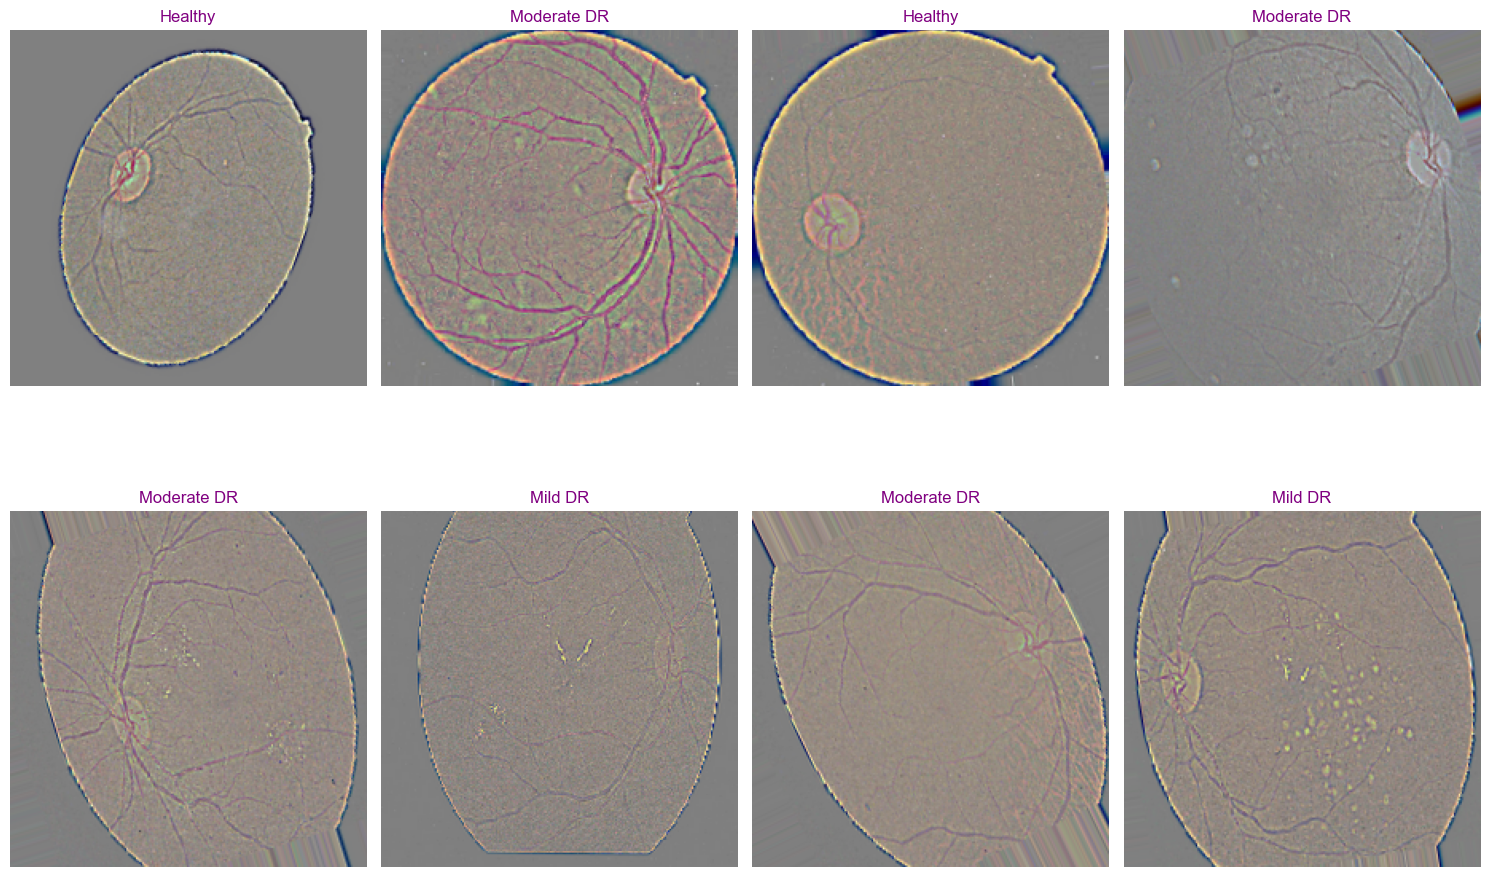

In [8]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)
    
    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

In [13]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=56086026c4820b59994c0bc22fd9fb5ca2d38ef6fb71ba920d360ad91afbbddc
  Stored in directory: /Users/kunalgoyal/Library/Caches/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [15]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
import ssl
from PIL import Image
from efficientnet_pytorch import EfficientNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import get_file
import contextlib
from urllib.request import urlretrieve
import tensorflow as tf

# Disable SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Install efficientnet-pytorch
!pip install efficientnet-pytorch

# Define number of classes 
n_classes = len(list(Train.class_indices.keys()))

img_shape = (img_size[0], img_size[1], 3)
model_name = 'EfficientNetB3'
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max') 

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable = True
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001)(x)
x = Dense(1024, 
          kernel_regularizer=regularizers.l2(0.01), 
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005), 
          activation='relu')(x)
x = Dropout(rate=.2, seed=123)(x)
x = Dense(512, 
          kernel_regularizer=regularizers.l2(0.01), 
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005), 
          activation='relu')(x)
x = Dropout(rate=.3, seed=123)(x)
x = Dense(256, 
          kernel_regularizer=regularizers.l2(0.01), 
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005), 
          activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)
output = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
lr = .0001  # start with this learning rate


In [16]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))

In [17]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [23]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Build the model
dummy_input = tf.zeros((1, img_size[0], img_size[1], 3))
model(dummy_input)


<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.00882679, 0.8814356 , 0.00243253, 0.00734979, 0.09995544]],
      dtype=float32)>

In [25]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [28]:
epochs = 10
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.4823 - loss: 1.8753 - val_accuracy: 0.5164 - val_loss: 1.5265
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 406s 4s/step - accuracy: 0.6215 - loss: 1.0354 - val_accuracy: 0.6036 - val_loss: 1.0177
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.6674 - loss: 0.8714 - val_accuracy: 0.6545 - val_loss: 0.8864
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.7185 - loss: 0.7440 - val_accuracy: 0.6473 - val_loss: 0.8588
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 396s 4s/step - accuracy: 0.7187 - loss: 0.7121 - val_accuracy: 0.6545 - val_loss: 0.8153
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 409s 4s/step - accuracy: 0.7528 - loss: 0.6598 - val_accuracy: 0.6727 - val_loss: 0.8760
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.7514 - loss: 0.6512 - val_accuracy: 0.6509 - val_loss: 0.9546
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 414s 4s/step - accuracy: 0.7712 - loss: 0.5878 - val_accu

In [33]:
# accuracy and loss of Train
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']

# accuracy and loss of Valid
v_acc = history.history['val_accuracy']
v_loss = history.history['val_loss']

# highest value of v_acc by getting its index
index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]

# lowest value of v_loss by getting index
index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]

# n. of epochs based on length of tr_acc values
Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)

# Define best epoch
best_acc = f'Best epoch = {str(index_acc + 1)}'
best_loss = f'Best epoch = {str(index_loss + 1)}'

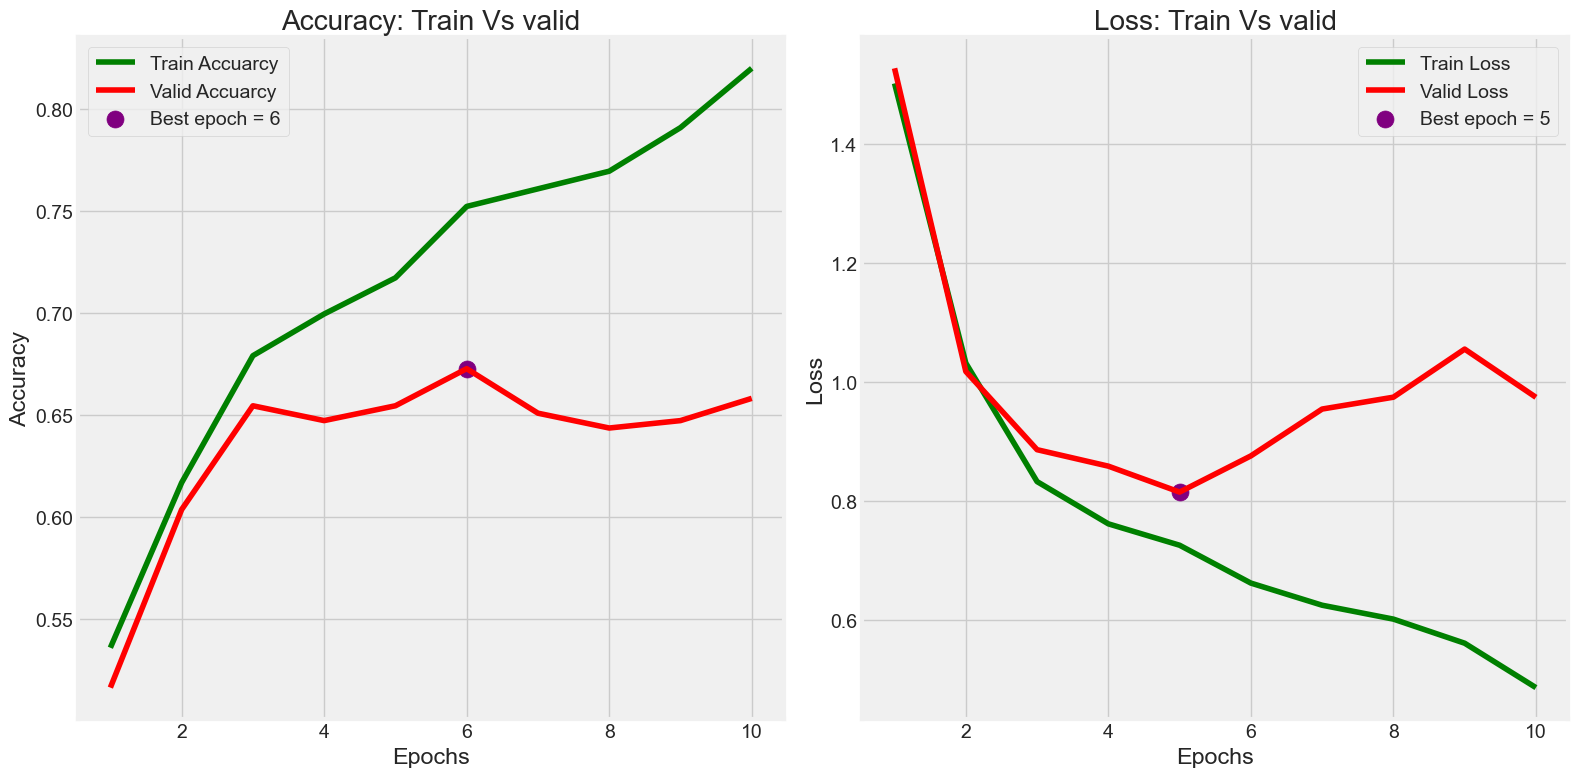

In [34]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 469ms/step - accuracy: 0.8846 - loss: 0.3163
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step - accuracy: 0.6458 - loss: 0.9621
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step - accuracy: 0.7471 - loss: 0.7158
Train Scores : 
    accuracy: 0.8840909004211426 
      Loss:  0.3188604712486267 
________________________
Valid Scores : 
    accuracy: 0.6581818461418152 
      Loss:  0.9743349552154541 
________________________
Test Scores : 
    accuracy: 0.7381818294525146 
      Loss:  0.8074917197227478 
________________________


In [37]:
predictions = model.predict(Test)
y_pred = np.argmax(predictions, axis=1)

# Check
print(predictions)
print(y_pred)


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 551ms/step
[[8.16511642e-03 9.39459085e-01 4.44510058e-02 4.03783005e-03
  3.88686126e-03]
 [8.70333195e-01 3.38483304e-02 9.51832309e-02 2.12328319e-04
  4.22984711e-04]
 [9.99929667e-01 9.79524975e-06 6.05633686e-05 2.74859580e-10
  1.38826373e-09]
 ...
 [9.04425222e-04 7.02654600e-01 2.75428474e-01 8.99111759e-03
  1.20214550e-02]
 [9.99671102e-01 2.57329346e-04 7.12274705e-05 2.97279257e-07
  1.16005275e-07]
 [3.37305695e-01 1.06017277e-01 4.84181613e-01 1.66751128e-02
  5.58202900e-02]]
[1 0 0 2 2 0 4 2 0 0 2 0 2 0 4 3 2 2 2 0 0 0 0 2 2 2 2 2 2 2 2 0 0 3 0 1 2
 1 2 2 0 4 2 0 2 1 0 2 0 0 2 1 1 1 2 0 0 0 1 0 0 2 0 3 0 2 1 0 1 4 1 2 0 1
 0 2 1 2 0 0 2 2 1 2 0 1 1 2 2 2 0 2 2 2 0 2 1 4 3 0 2 2 1 2 1 0 0 1 1 4 2
 0 1 1 0 2 0 1 2 1 0 1 0 4 1 2 1 0 2 1 0 2 0 2 2 2 2 0 0 0 0 0 1 0 1 1 0 0
 1 2 0 0 0 0 1 0 0 2 4 2 2 4 2 0 1 0 0 0 2 0 2 1 1 2 1 1 0 0 2 4 0 0 2 3 0
 2 0 0 2 2 2 0 2 1 1 1 2 2 2 2 2 2 0 1 0 3 1 2 2 0 1 0 1 2 1 0 2 0 2 0 2 2
 2 0 2 3 2 2 0 0 1 0 0 

In [41]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices
 
# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[95,  2,  0,  0,  0],
       [ 2, 26,  7,  1,  0],
       [ 1, 21, 72,  1,  5],
       [ 2,  4, 10,  4,  2],
       [ 0,  1, 12,  1,  6]])

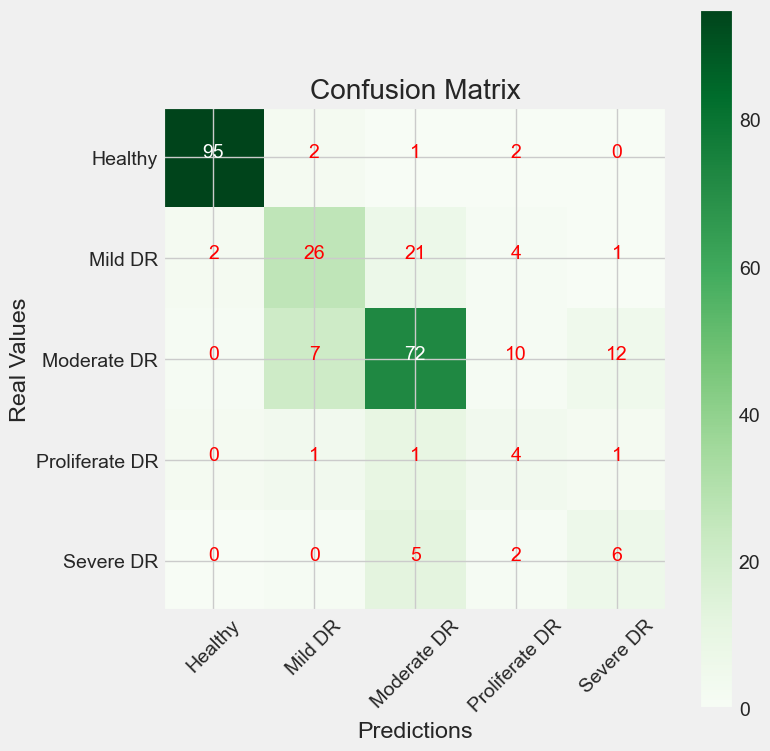

In [42]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')
    
plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [43]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))


                precision    recall  f1-score   support

       Healthy       0.95      0.98      0.96        97
       Mild DR       0.48      0.72      0.58        36
   Moderate DR       0.71      0.72      0.72       100
Proliferate DR       0.57      0.18      0.28        22
     Severe DR       0.46      0.30      0.36        20

      accuracy                           0.74       275
     macro avg       0.64      0.58      0.58       275
  weighted avg       0.74      0.74      0.72       275



In [51]:
model.save('effB3_CNN_DR_new.keras')  # saves the model in the native Keras format
